# 🚀 LangGraph Workflow with Web Search Integration

📚 Import Libraries

In [29]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from serpapi import GoogleSearch
from langchain_core.pydantic_v1 import BaseModel, Field
import pandas as pd
import os

### 🔍 What's happening here?
- We're importing all the necessary libraries for our LangGraph workflow. This includes components from LangChain, LangGraph, and other utilities for web searching and data manipulation.
---

🧠 Initialize the Language Model

In [30]:
llm=ChatOpenAI(model="gpt-4o", 
               temperature=1.0,
               max_tokens=1000, 
               top_p=1.0, 
               frequency_penalty=0.0, 
               presence_penalty=0.0,
               api_key=os.environ["OPENAI_API_KEY"])

## 🎛️ Model Configuration:

- We're using the GPT-4 model with specific parameters for creativity and response length.
- The API key is securely stored in an environment variable.
---

🌐 Web Search Tool

In [31]:
@tool
def web_search(query: str) -> str:
    """Call to surf the web for mortgage interest rates news in that particular year """
    params = {
                "engine": "google",
                "q": query,
                "api_key": os.environ["SERPAPI_API_KEY"],
            }

    search = GoogleSearch(params)
    results = search.get_dict()
    return results

## 🔎 Tool Functionality:

- This custom tool allows our LangGraph to perform web searches.
- It uses the SerpAPI to query Google and return results.
- The @tool decorator makes it compatible with our LangChain setup.
---

🔗 LLM and Tool Integration

In [32]:
tools = [web_search]
llm=llm.bind_tools(tools)
tool_node = ToolNode(tools)

## 🛠️ Integration Steps:

- We create a list of tools (currently just our web search).
- The language model is bound to these tools, allowing it to use them.
- A ToolNode is created for use in our LangGraph workflow.
---

🔄 Workflow Control Functions
- *Continuation Decision*

In [33]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

## 🤔 Decision Logic:

- This function decides whether to continue using tools or end the workflow.
- If the last message includes tool calls, we continue; otherwise, we end.
---

Model Invocation

In [34]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

## 💬 Model Interaction:

- This function handles calling our language model with the current state.
- It returns the model's response as a new message in the state.
---

📊 LangGraph Workflow Setup

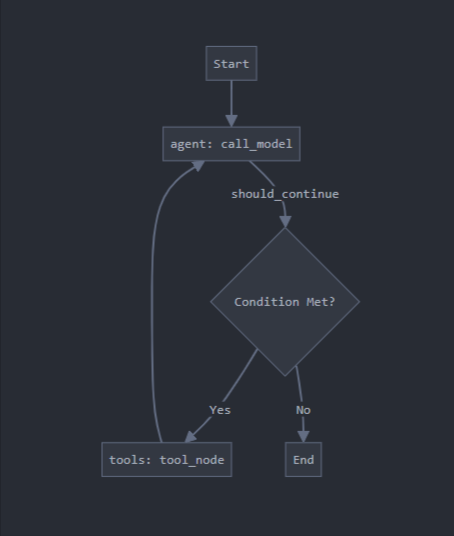

In [35]:
# Initializing the workflow
workflow = StateGraph(MessagesState)
# Adding nodes to the workflow (LLM invoke function , tools)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
# Setting the entry point of the workflow
workflow.set_entry_point("agent")
# Adding conditional edges to the workflow (if the condition is met, the workflow will move to the next node)
workflow.add_conditional_edges("agent",should_continue,)
# Adding edges to the workflow (tools, agent)
workflow.add_edge("tools", 'agent')

## 🏗️ Graph Structure:

- We create a StateGraph to manage our workflow.
- Two nodes are added: one for the agent (our LLM) and one for tools.
- Conditional edges determine the flow based on the should_continue function.
---

⚙️ Compile the Workflow

In [36]:
app = workflow.compile()

🚀 Invocation Function

In [37]:
def invoke(prompt):
    final_state = app.invoke({"messages": [HumanMessage(content=prompt)]},
                            config={"configurable": {"thread_id": 42}})
    return final_state["messages"][-1].content

## 📣 Function Purpose:

- This is our main interface for using the workflow.
- It takes a prompt, runs it through the entire workflow, and returns the final response.
---

📝 Example Usage

In [38]:
def generate(year_range,location):
    prompts=[]
    responses=[]
    years=[i for i in range(year_range[0], year_range[1]+1)]
    prompt='''
            what happened in mortgage in the housing industry for interest rates in {year} in {location}?  
            give me a short summary of the events that happened in the mortgage industry in {year} in {location} in this format:
              - interest rates
              - average house price in the location
              - trend going up or down
              - cause for the trend
            '''
    for year in years:
        current_prompt=prompt.format(year=year, location=location)
        prompts.append(current_prompt)
        responses.append(invoke(current_prompt))
    data=pd.DataFrame({'Year':years, 'Location':location, 'Event':responses})
    data.to_excel(f'results/{location}_{year_range[0]}_{year_range[1]}.xlsx', index=False) 


## 🎯 Putting It All Together:

- This example shows how to use our LangGraph workflow for multiple queries.
- We define a list of prompts, generate responses for each, and store the results in an Excel file.
---



In [39]:
generate([2015,2024],'USA')

🌟 Conclusion
This notebook demonstrates a powerful LangGraph workflow that combines language models with web search capabilities. You can adapt this structure for various information retrieval and analysis tasks by modifying the prompts and processing logic as needed. Happy exploring! 🚀🔍🤖